In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import seaborn as sns
import pingouin as pg
from matplotlib.colors import ListedColormap
from scipy import stats
pd.options.mode.chained_assignment = None

In [2]:
measurements = pd.read_excel(r'Z:\grodriguez\CardiacOCT\code\count-distributions\manual_vs_automatic_measures.xlsx', sheet_name='Calcium new test set')

In [96]:
pullback_df = measurements[measurements['pullback'] == 'NLD-AMPH-0028'].reset_index(drop=True)

## Functions

In [3]:
def get_data_filtered(test_sheet, type_manual, type_ai, missing = -99):

    manual = test_sheet[type_manual]

    ai = test_sheet[type_ai]

    list_fp = []
    list_fn = []
    list_nulls = []
    list_drops = []
    fp_count = 0
    fn_count = 0

    for value in range(len(manual)):

        if manual[value] == missing and ai[value] != missing:
            list_fp.append(value)
            fp_count += 1

        if manual[value] != missing and ai[value] == missing:
            list_fn.append(value)
            fn_count += 1

        if manual[value] == missing and ai[value] == missing:
            list_nulls.append(value)

        if ai[value] == np.nan:
            list_nulls.append(value)

    list_drops.extend(list_fp)
    list_drops.extend(list_fn)
    list_drops.extend(list_nulls)

    ai.drop(list_drops, inplace=True)
    manual.drop(list_drops, inplace=True)

    print('Found {} FP and {} FN. Total values are {}'.format(fp_count, fn_count, len(manual)))


    return manual, ai

In [4]:
def corr_plot(manual, automatic, thresh, title):

    print('Corr {}: {}'.format(title, np.corrcoef(manual, automatic)))

    col = []
    for i, j in zip(manual, automatic):
        if i <= thresh and j >= thresh:
            col.append(0)

        elif i >= thresh and j <= thresh:
            col.append(1)

        else:
            col.append(2)

    classes = ['FP', 'FN', 'TP/TN']
    if all(c == 2 for c in col):
        scatter = plt.scatter(manual, automatic, c='blue')
        plt.legend(handles=[scatter], labels=['TP/TN'])

    else:
        scatter = plt.scatter(manual, automatic, c=col, cmap=ListedColormap(['black', 'green', 'blue']))
        plt.axhline(thresh, color='r')
        plt.axvline(thresh, color='r')
        plt.xlabel('Manual')
        plt.ylabel('Automatic')
        plt.title(title)
        plt.legend(handles=scatter.legend_elements()[0], labels = classes)
        plt.show()

In [5]:
def calculate_icc(automatic_values, manual_values):

    raters1 = ['Automatic' for _ in range(len(automatic_values))]
    raters2 = ['Manual' for _ in range(len(automatic_values))]
    raters1.extend(raters2)

    exam1 = list(np.arange(0, len(automatic_values)))
    exam2 = list(np.arange(0, len(automatic_values)))
    exam1.extend(exam2)

    values_fct = pd.concat([automatic_values, manual_values])

    icc_df = pd.DataFrame({'exam': exam1, 'raters': raters1, 'fct': values_fct})

    icc = pg.intraclass_corr(icc_df, 'exam', 'raters', 'fct')

    return icc

In [6]:
def find_outliers(automatic_values, manual_values, sheet, score):

    differences = automatic_values - manual_values

    if score == 'zscore':
        # Method 1: Z-score
        z_scores = stats.zscore(differences)
        z_score_threshold = 3.0
        outliers = np.where(np.abs(z_scores) > z_score_threshold)[0]

    elif score == 'tukey':
        # Method 2: Tukey's fences
        q1 = np.percentile(differences, 25)
        q3 = np.percentile(differences, 75)
        iqr = q3 - q1
        lower_fence = q1 - (1.5 * iqr)
        upper_fence = q3 + (1.5 * iqr)
        outliers = np.where((differences < lower_fence) | (differences > upper_fence))[0]

    else:
        raise ValueError('Wrong type')

    outliers_data = []

    for outlier in outliers:

        value = automatic_values.index[outlier]    
        outlier_pullback = sheet.iloc[value]['pullback']
        outlier_frame = sheet.iloc[value]['frame']
        outlier_ai = automatic_values.tolist()[outlier]
        outlier_manual = manual_values.tolist()[outlier]

        outliers_data.append({'pullback': outlier_pullback, 'frame': outlier_frame, 'ai': outlier_ai, 'manual': outlier_manual})

    return outliers, outliers_data

# Bland Altman manual vs automatic

Found 8 FP and 4 FN. Total values are 28
43.58903332870106


Text(0.5, 1.0, 'Depth manual vs automatic')

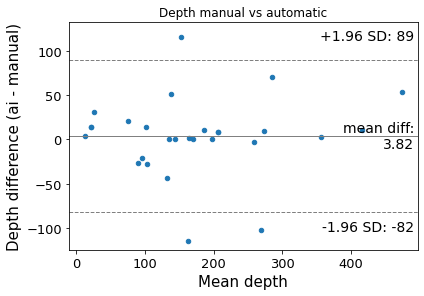

In [8]:
manual_depth, ai_depth = get_data_filtered(measurements, 'Depth test set', 'Depth model 7')
mean = np.mean([manual_depth, ai_depth], axis=0)
diff = manual_depth - ai_depth                  
md = np.mean(diff)                   
sd = np.std(diff, axis=0) 
print(sd)

fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(ai_depth, manual_depth, ax = axes)
plt.xlabel('Mean depth')
plt.ylabel('Depth difference (ai - manual)')
plt.title('Depth manual vs automatic')

In [9]:
outliers, outliers_data = find_outliers(ai_depth, manual_depth, measurements, 'tukey')
print(outliers)
print(outliers_data)

[ 2  5  8 15 17 20 25 26 27]
[{'pullback': 'NLD-AMPH-0028', 'frame': 177, 'ai': 210, 'manual': 94}, {'pullback': 'NLD-AMPH-0054', 'frame': 168, 'ai': 163, 'manual': 112}, {'pullback': 'NLD-AMPH-0054', 'frame': 244, 'ai': 106, 'manual': 220}, {'pullback': 'NLD-ISALA-0057', 'frame': 400, 'ai': 320, 'manual': 250}, {'pullback': 'NLD-ISALA-0073', 'frame': 200, 'ai': 501, 'manual': 447}, {'pullback': 'NLD-ISALA-0087', 'frame': 339, 'ai': 76, 'manual': 103}, {'pullback': 'NLD-ISALA-0097', 'frame': 350, 'ai': 89, 'manual': 117}, {'pullback': 'NLD-ISALA-0097', 'frame': 360, 'ai': 110, 'manual': 153}, {'pullback': 'NLD-ISALA-0097', 'frame': 400, 'ai': 218, 'manual': 320}]


Found 8 FP and 4 FN. Total values are 28
16.910931134527594


Text(0.5, 1.0, 'Calcium arc manual vs automatic')

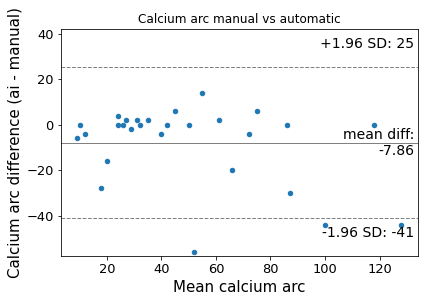

In [10]:
manual_arc, ai_arc = get_data_filtered(measurements, 'Arc test set', 'Arc model 7')
mean = np.mean([manual_arc, ai_arc], axis=0)
diff = manual_arc - ai_arc                   
md = np.mean(diff)                   
sd = np.std(diff, axis=0) 
print(sd)

fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(ai_arc, manual_arc, ax = axes)
plt.xlabel('Mean calcium arc')
plt.ylabel('Calcium arc difference (ai - manual)')
plt.title('Calcium arc manual vs automatic')


In [11]:
outliers, outliers_data = find_outliers(ai_arc, manual_arc, measurements, 'tukey')
print(outliers)
print(outliers_data)

[ 2  3  9 12 15]
[{'pullback': 'NLD-AMPH-0028', 'frame': 177, 'ai': 24, 'manual': 80}, {'pullback': 'NLD-AMPH-0028', 'frame': 179, 'ai': 72, 'manual': 102}, {'pullback': 'NLD-AMPH-0054', 'frame': 280, 'ai': 106, 'manual': 150}, {'pullback': 'NLD-ISALA-0057', 'frame': 200, 'ai': 78, 'manual': 122}, {'pullback': 'NLD-ISALA-0057', 'frame': 400, 'ai': 4, 'manual': 32}]


Found 8 FP and 4 FN. Total values are 28
179.65671275734593


Text(0.5, 1.0, 'Calcium thickness manual vs automatic')

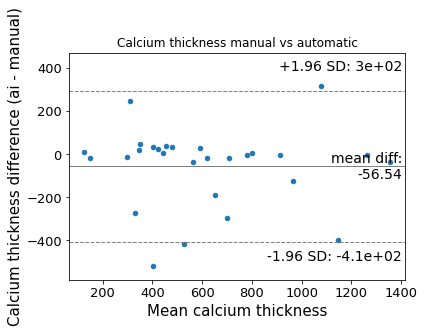

In [12]:
manual_thickness, ai_thickness = get_data_filtered(measurements, 'Thickness test set', 'Thickness model 7')
mean = np.mean([manual_thickness, ai_thickness], axis=0)
diff = manual_thickness - ai_thickness                   
md = np.mean(diff)                   
sd = np.std(diff, axis=0) 
print(sd)


fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(ai_thickness, manual_thickness, ax = axes)
plt.xlabel('Mean calcium thickness')
plt.ylabel('Calcium thickness difference (ai - manual)')
plt.title('Calcium thickness manual vs automatic')

In [13]:
outliers, outliers_data = find_outliers(ai_thickness, manual_thickness, measurements, 'tukey')
print(outliers)
print(outliers_data)

[ 2 15 17 19 21 25 26 27]
[{'pullback': 'NLD-AMPH-0028', 'frame': 177, 'ai': 318, 'manual': 735}, {'pullback': 'NLD-ISALA-0057', 'frame': 400, 'ai': 143, 'manual': 664}, {'pullback': 'NLD-ISALA-0073', 'frame': 200, 'ai': 192, 'manual': 465}, {'pullback': 'NLD-ISALA-0087', 'frame': 280, 'ai': 432, 'manual': 186}, {'pullback': 'NLD-ISALA-0087', 'frame': 440, 'ai': 555, 'manual': 747}, {'pullback': 'NLD-ISALA-0097', 'frame': 350, 'ai': 550, 'manual': 848}, {'pullback': 'NLD-ISALA-0097', 'frame': 360, 'ai': 1236, 'manual': 920}, {'pullback': 'NLD-ISALA-0097', 'frame': 400, 'ai': 946, 'manual': 1347}]


## Pearson and ICC

Corr Depth: [[1.         0.92883695]
 [0.92883695 1.        ]]


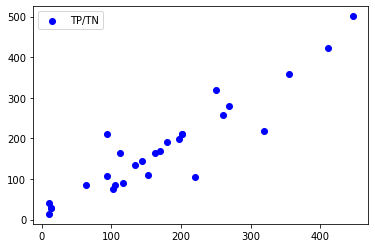

In [14]:
corr_plot(manual_depth, ai_depth, 0, 'Depth')

Corr Calcium arc: [[1.        0.8821796]
 [0.8821796 1.       ]]


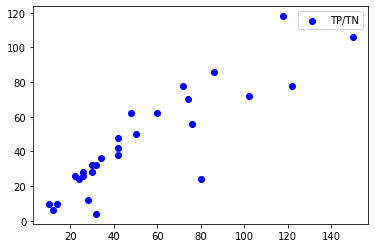

In [15]:
corr_plot(manual_arc, ai_arc, 180, 'Calcium arc')

Corr Calcium thickness: [[1.         0.85305421]
 [0.85305421 1.        ]]


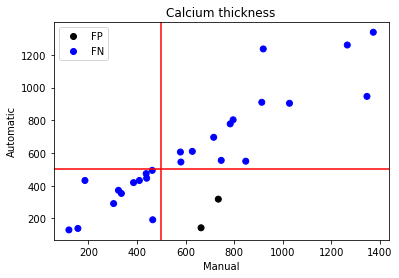

In [16]:
corr_plot(manual_thickness, ai_thickness, 500, 'Calcium thickness')

In [17]:
calculate_icc(ai_depth, manual_depth)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.930397,27.734229,27,28,5.699588e-14,"[0.86, 0.97]"
1,ICC2,Single random raters,0.930326,26.949271,27,27,1.991944e-13,"[0.86, 0.97]"
2,ICC3,Single fixed raters,0.928442,26.949271,27,27,1.991944e-13,"[0.85, 0.97]"
3,ICC1k,Average raters absolute,0.963943,27.734229,27,28,5.699588e-14,"[0.92, 0.98]"
4,ICC2k,Average random raters,0.963906,26.949271,27,27,1.991944e-13,"[0.92, 0.98]"
5,ICC3k,Average fixed raters,0.962893,26.949271,27,27,1.991944e-13,"[0.92, 0.98]"


In [18]:
calculate_icc(ai_arc, manual_arc)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.845368,11.933960,27,28,2.318325e-09,"[0.7, 0.93]"
1,ICC2,Single random raters,0.847107,13.991936,27,27,6.131304e-10,"[0.67, 0.93]"
2,ICC3,Single fixed raters,0.866595,13.991936,27,27,6.131304e-10,"[0.73, 0.94]"
3,ICC1k,Average raters absolute,0.916206,11.933960,27,28,2.318325e-09,"[0.82, 0.96]"
4,ICC2k,Average random raters,0.917226,13.991936,27,27,6.131304e-10,"[0.8, 0.96]"
5,ICC3k,Average fixed raters,0.928530,13.991936,27,27,6.131304e-10,"[0.85, 0.97]"


In [19]:
calculate_icc(ai_thickness, manual_thickness)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.844787,11.885505,27,28,2.433862e-09,"[0.69, 0.92]"
1,ICC2,Single random raters,0.845463,12.595987,27,27,2.107234e-09,"[0.69, 0.93]"
2,ICC3,Single fixed raters,0.852898,12.595987,27,27,2.107234e-09,"[0.71, 0.93]"
3,ICC1k,Average raters absolute,0.915864,11.885505,27,28,2.433862e-09,"[0.82, 0.96]"
4,ICC2k,Average random raters,0.916261,12.595987,27,27,2.107234e-09,"[0.82, 0.96]"
5,ICC3k,Average fixed raters,0.920610,12.595987,27,27,2.107234e-09,"[0.83, 0.96]"
